<a href="https://colab.research.google.com/github/lawrencegranda/garbage_classification/blob/main/GARBAGE_CLASSIFICATION001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Garbage Classification Model 001**

## Install and import dependencies

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install pandas
!pip install tensorflow_hub
!pip install sklearn
!pip install -U tensorflow_datasets

# !pip install google-colab
# from google.colab import output
# output.clear()

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Attention, Lambda
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import math
import numpy as np
import pandas as pd
import random
import os
import glob
from PIL import Image
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load Kaggle dataset

In [ ]:
!git clone https://github.com/yourusername/yourpublicrepo.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle competitions download -c tabular-playground-series-mar-2022
! unzip -o train.csv.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
  inflating: train.csv               


## Feature Engineering

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.set_index('row_id',inplace=True)

test_df = pd.read_csv('test.csv')
test_df.set_index('row_id',inplace=True)

train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.24,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5,random_state=42)

test_df.shape, x_train.shape

((2340, 20), (645114, 20))

## Parameters and Info

In [ ]:
info = {
    'total': len(y_train) + len(y_test) + len(y_val),
    'train': len(y_train),
    'val': len(y_val),
    'test': len(y_test),
    'shape': x_test.shape[1:],
}

print("Number of training examples:    {}".format(info['train']))
print("Number of validation examples:  {}".format(info['val']))
print("Number of test examples:        {}".format(info['test']))
print("Number of total examples:       {}".format(info['total']))

Number of training examples:    645114
Number of validation examples:  101860
Number of test examples:        101861
Number of total examples:       848835


In [ ]:
LEARNING_RATE = 5e-5
BATCH_SIZE = 5000
VERBOSE = 0
PATIENCE = 60
EPOCHS = 300

## Building the model

In [ ]:
def build_model(input_shape, learning_rate=LEARNING_RATE):
    inputs = tf.keras.Input(shape=input_shape, name="Input")

    # x = Dense(1024, name="Dense-01", activation='relu')(inputs)

    x = Dense(512, name="Dense-02", activation='relu')(inputs)

    x = Dense(256, name="Dense-1", activation='relu')(x)
    # x = Dropout(0.1)(x)

    x = Dense(128, name="Dense-2", activation='relu')(x)
    # x = Dropout(0.1)(x)
    
    x = Dense(64, name="Dense-3", activation='relu')(x)
    # x = Dropout(0.1)(x)
    
    x = Dense(32, name="Dense-4", activation='relu')(x)
    # x = Dropout(0.1)(x)

    x = Dense(16, name="Dense-5", activation='relu')(x)
    # x = Dropout(0.1)(x)

    x = Dense(8, name="Dense-6", activation='relu')(x)
    # x = Dropout(0.1)(x)
    
    x = Dense(4, name="Dense-7", activation='relu')(x)
    # x = Dropout(0.1)(x)
    
    x = Dense(2, name="Dense-8", activation='relu')(x)
    # x = Dropout(0.1)(x)
    
    outputs = Dense(1, name="Output", activation='relu')(x)


    model_title = "Linear_Regression"
    model = tf.keras.Model(inputs, outputs, name=model_title)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mae',
                metrics=['mae', 'mse'])

    return model, model_title

Model: "Linear_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20)]              0         
                                                                 
 Dense-02 (Dense)            (None, 512)               10752     
                                                                 
 Dense-1 (Dense)             (None, 256)               131328    
                                                                 
 Dense-2 (Dense)             (None, 128)               32896     
                                                                 
 Dense-3 (Dense)             (None, 64)                8256      
                                                                 
 Dense-4 (Dense)             (None, 32)                2080      
                                                                 
 Dense-5 (Dense)             (None, 16)          

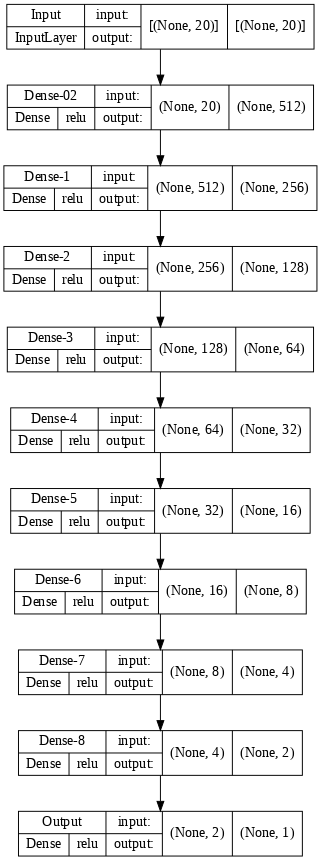

In [ ]:
myModel, myModel_title = build_model(input_shape=info['shape'], learning_rate=LEARNING_RATE)

myModel.summary()
tf.keras.utils.plot_model(myModel, show_shapes=True,show_layer_activations=True, to_file="{}.png".format(myModel_title), dpi=70)

## Training

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training \n")

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("\n\nEnd of training\nThe validation loss is {:.4f}"
        .format(logs["val_loss"]))

    def on_epoch_end(self, epoch, logs=None):
        if VERBOSE<=0:
            if epoch%20 == 0 and epoch>=20:
                keys = list(logs.keys())
                print("\nThe validation loss is {:.4f}".format(logs["val_loss"]))

            print(epoch+1, end=" ")


EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

In [ ]:
def train(model, x_train, y_train, x_val, y_val, epochs=EPOCHS, batch_size=64):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=VERBOSE,
        callbacks=[CustomCallback(), EarlyStopping]
        )

    # Save the weights
    from datetime import datetime
    myModel.save('./models/kaggle_tabular_2022-03_001_Time{}.h5'.format(str(datetime.now().time())), overwrite=True)
    return model, history.history

In [ ]:
myModel, myHistory = train(myModel, x_train, y_train, x_val, y_val, batch_size=BATCH_SIZE)

Starting training 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
The validation loss is 47.7656
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

KeyboardInterrupt: ignored

## Evaluation

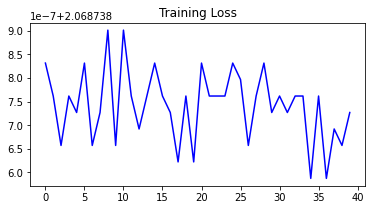

In [ ]:
def plotLoss(history):
    BEGINNING = 20
    END = -1
    loss = np.log1p(np.sqrt(history['loss']))[BEGINNING:END]

    epochs_range = range(len(loss))

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_range, loss, label='Training Loss', c='blue')
    plt.title('Training Loss')
    plt.show()

plotLoss(myHistory)